In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import time

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Set the paths for training and testing data
train_data_dir = 'Latest Dataset/Train'
test_data_dir = 'Latest Dataset/Test'
CATEGORIES = ["Anger", "Joy", "Natural", "Sadness"]
IMG_SIZE = 128

# Define image size and batch size
img_size = (128, 128)
batch_size = 16

In [2]:
def detect_face(image_path, face_cascade):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    if len(faces) == 0:
        return None
    (x, y, w, h) = faces[0]  # Assuming one face per image
    face = gray[y:y+h, x:x+w]
    return cv2.resize(face, (128, 128))  # Resize to a fixed size

In [3]:
# Initialize the Haar Cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

**Preprocess Dataset**

In [4]:
features = []
labels = []

for label, category in enumerate(CATEGORIES):
    class_dir = os.path.join(train_data_dir, category)
    if not os.path.isdir(class_dir):
        continue

    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        face = detect_face(image_path, face_cascade)
        
        if face is not None:
            features.append(face.flatten())
            labels.append(label)

images = np.array(features)
labels = np.array(labels)

In [5]:
# Convert lists to numpy arrays
features = np.array(features)
labels = np.array(labels)

# Normalize the data
scaler = StandardScaler()
features = scaler.fit_transform(features)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

## Feature Extraction - PCA + LDA

**Computational Performance Metrics (Time)**

In [7]:
start_time = time.time()

# Apply PCA
pca = PCA(svd_solver='randomized', n_components=64, whiten=True)

# Transform the data
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

lda = LinearDiscriminantAnalysis(n_components=len(CATEGORIES) - 1)
X_train_lda = lda.fit_transform(X_train_pca, y_train)
X_test_lda = lda.transform(X_test_pca)

end_time = time.time()
execution_time = end_time - start_time
print(f'Feature extraction time: {execution_time} seconds')

Feature extraction time: 3.921335458755493 seconds


In [8]:
X_train_lda.shape

(416, 3)

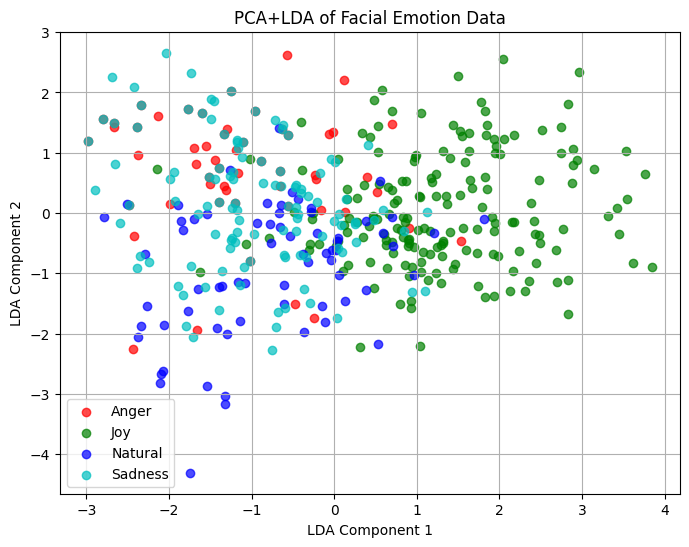

In [9]:
# Plot the LDA-transformed data
plt.figure(figsize=(8, 6))
colors = ['r', 'g', 'b', 'c', 'm', 'y']
for i, color in zip(range(len(CATEGORIES)), colors):
    plt.scatter(X_train_lda[y_train == i, 0], X_train_lda[y_train == i, 1], alpha=0.7, color=color, label=CATEGORIES[i])

plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.title('PCA+LDA of Facial Emotion Data')
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.grid(True)
plt.show()

In [10]:
X_train_lda.shape

(416, 3)

## Fit to model

In [11]:
# Convert labels to categorical
y_train_cat = to_categorical(y_train, num_classes=len(CATEGORIES))
y_test_cat = to_categorical(y_test, num_classes=len(CATEGORIES))

In [12]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, multiply
import tensorflow.keras.backend as K

def se_block(in_block, ch, ratio=16):
    # Squeeze: Global Average Pooling converts each channel to a single numerical value
    y = GlobalAveragePooling2D()(in_block)
    
    # Excitation: Two Dense blocks transform the n values to n weights for each channel
    y = Dense(ch // ratio, activation='relu')(y)  # The first layer with a ReLU activation
    y = Dense(ch, activation='sigmoid')(y)        # The second (last) layer with a sigmoid activation (acting as a smooth gating function)
    
    # Scale and Combine: Apply weights to the channels by element-wise multiplication
    return multiply([in_block, y])

In [13]:
# Define the neural network architecture
input_shape = X_train_lda.shape[1]
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(input_shape,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(4, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_lda, y_train_cat, epochs=50, batch_size=32, validation_data=(X_test_lda, y_test_cat), shuffle=True)

Epoch 1/50


d:\FYP Face Recognition\virtual_env\Lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.2502 - loss: 2.4029 - val_accuracy: 0.5048 - val_loss: 1.3932
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2874 - loss: 2.0389 - val_accuracy: 0.5333 - val_loss: 1.3465
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3611 - loss: 1.8620 - val_accuracy: 0.4952 - val_loss: 1.3168
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4059 - loss: 1.6042 - val_accuracy: 0.4857 - val_loss: 1.2933
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4644 - loss: 1.5087 - val_accuracy: 0.4857 - val_loss: 1.2820
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4620 - loss: 1.6395 - val_accuracy: 0.4762 - val_loss: 1.2772
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4705 - loss: 1.5245 - val_accuracy: 0.4857 - val_loss: 1.2700
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4840 - loss: 1.4735 - val_accuracy: 0.4857 - val_loss: 1.2662
Ep

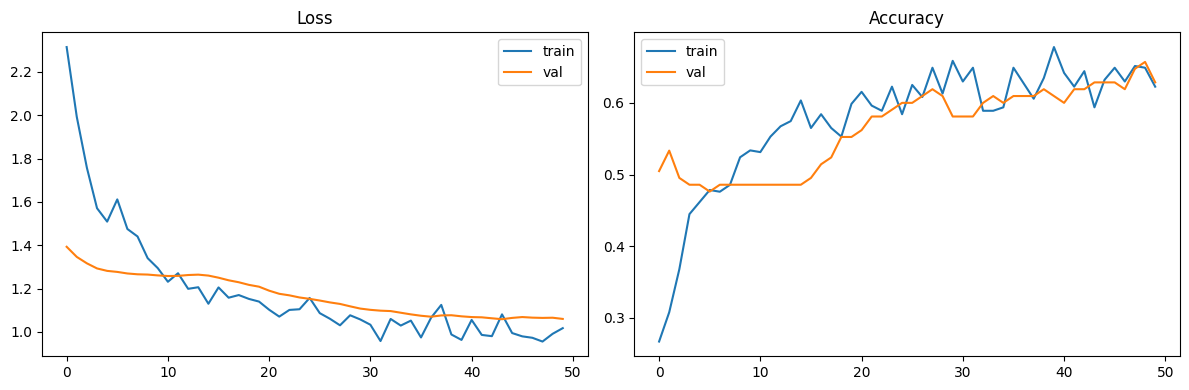

In [14]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_learning_curves(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Accuracy: 62.86%
              precision    recall  f1-score   support

       Anger       0.50      0.06      0.11        17
         Joy       0.77      0.86      0.81        50
     Natural       0.50      0.36      0.42        11
     Sadness       0.46      0.67      0.55        27

    accuracy                           0.63       105
   macro avg       0.56      0.49      0.47       105
weighted avg       0.62      0.63      0.59       105



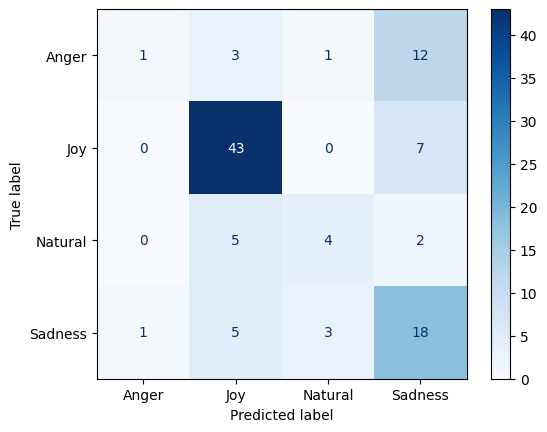

In [15]:
# Predict on the test set
y_pred_prob = model.predict(X_test_lda)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test_cat, axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test_labels, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(classification_report(y_test_labels, y_pred, target_names=CATEGORIES))

# Plot confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CATEGORIES)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Accuracy: 49.52%
              precision    recall  f1-score   support

       Anger       0.21      0.53      0.31        17
         Joy       0.87      0.66      0.75        50
     Natural       0.57      0.36      0.44        11
     Sadness       0.33      0.22      0.27        27

    accuracy                           0.50       105
   macro avg       0.50      0.44      0.44       105
weighted avg       0.59      0.50      0.52       105



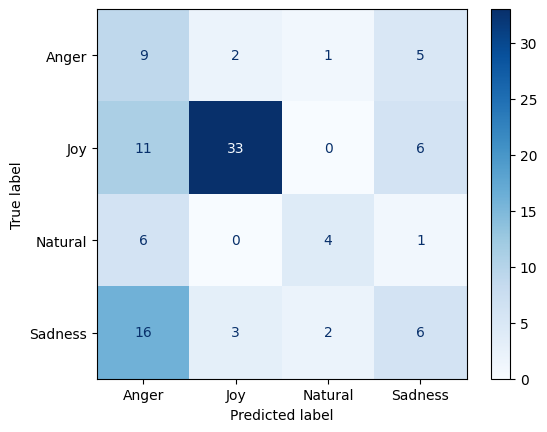

In [16]:
from sklearn.neural_network import MLPClassifier


mlp_clf = MLPClassifier(activation='relu', solver='adam', shuffle=True)
hist_mlp = mlp_clf.fit(X_train_lda, y_train_cat)

# Predict on the test set
y_pred_prob = mlp_clf.predict(X_test_lda)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test_cat, axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test_labels, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(classification_report(y_test_labels, y_pred, target_names=CATEGORIES))

# Plot confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CATEGORIES)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Accuracy: 56.19%
              precision    recall  f1-score   support

       Anger       0.36      0.24      0.29        17
         Joy       0.77      0.80      0.78        50
     Natural       0.40      0.55      0.46        11
     Sadness       0.33      0.33      0.33        27

    accuracy                           0.56       105
   macro avg       0.47      0.48      0.47       105
weighted avg       0.55      0.56      0.55       105



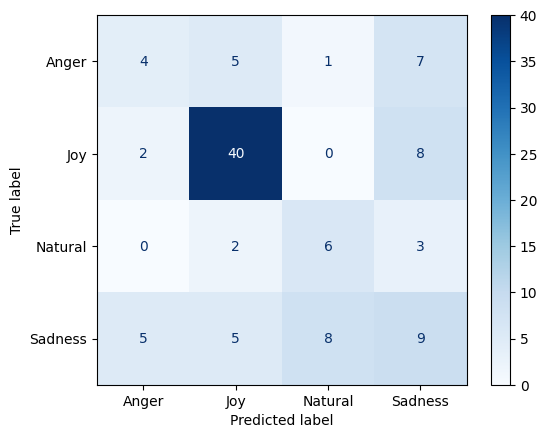

In [17]:
from sklearn.svm import SVC


svm = SVC(kernel='linear', random_state=42)
hist_svm = svm.fit(X_train_lda, y_train)

# Predict on the test set
y_pred_prob = svm.predict(X_test_lda)
y_pred = y_pred_prob

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(classification_report(y_test, y_pred, target_names=CATEGORIES))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CATEGORIES)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Accuracy: 56.19%
              precision    recall  f1-score   support

       Anger       0.35      0.35      0.35        17
         Joy       0.82      0.66      0.73        50
     Natural       0.57      0.73      0.64        11
     Sadness       0.35      0.44      0.39        27

    accuracy                           0.56       105
   macro avg       0.53      0.55      0.53       105
weighted avg       0.60      0.56      0.57       105



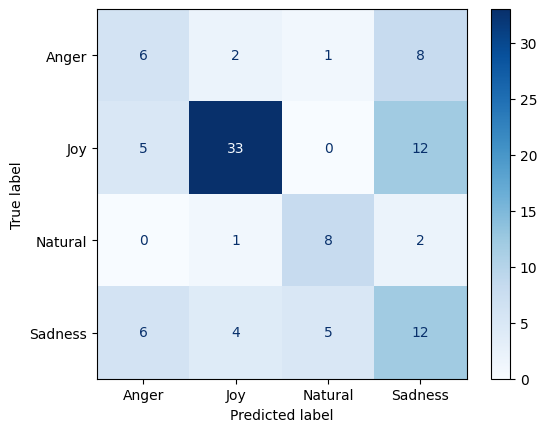

In [18]:
from sklearn.ensemble import AdaBoostClassifier

adaboost_clf = AdaBoostClassifier(n_estimators=100, algorithm="SAMME", random_state=0)
hist_ada = adaboost_clf.fit(X_train_lda, y_train)

# Predict on the test data
y_pred = adaboost_clf.predict(X_test_lda)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(classification_report(y_test, y_pred, target_names=CATEGORIES))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CATEGORIES)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Accuracy: 51.43%
              precision    recall  f1-score   support

       Anger       0.25      0.24      0.24        17
         Joy       0.90      0.70      0.79        50
     Natural       0.36      0.36      0.36        11
     Sadness       0.28      0.41      0.33        27

    accuracy                           0.51       105
   macro avg       0.45      0.43      0.43       105
weighted avg       0.58      0.51      0.54       105



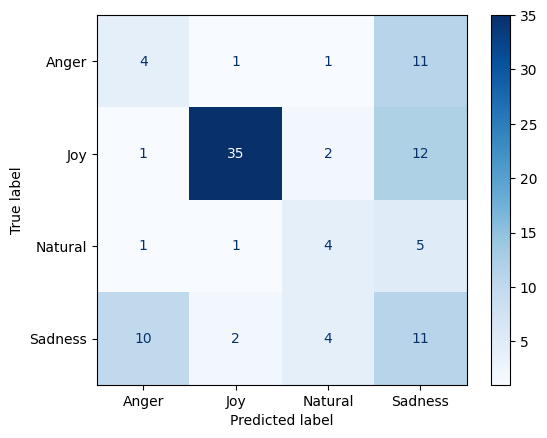

In [19]:
from sklearn.tree import DecisionTreeClassifier


decisiontree_clf = DecisionTreeClassifier()
hist_decision = decisiontree_clf.fit(X_train_lda, y_train)

# Predict on the test data
y_pred = decisiontree_clf.predict(X_test_lda)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(classification_report(y_test, y_pred, target_names=CATEGORIES))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CATEGORIES)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Accuracy: 57.14%
              precision    recall  f1-score   support

       Anger       0.29      0.24      0.26        17
         Joy       0.87      0.80      0.83        50
     Natural       0.38      0.45      0.42        11
     Sadness       0.34      0.41      0.37        27

    accuracy                           0.57       105
   macro avg       0.47      0.47      0.47       105
weighted avg       0.59      0.57      0.58       105



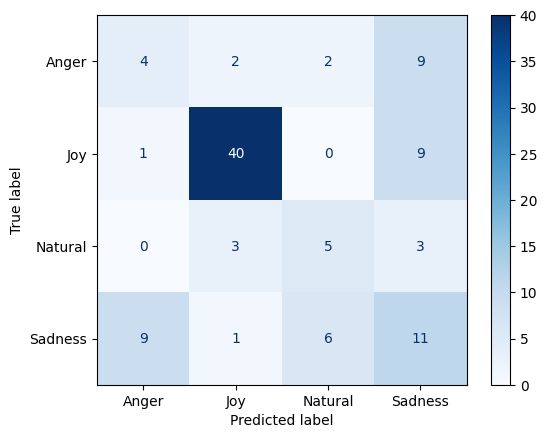

In [20]:
from sklearn.ensemble import RandomForestClassifier

randforest_clf = RandomForestClassifier()
hist_decision = randforest_clf.fit(X_train_lda, y_train)

# Predict on the test data
y_pred = randforest_clf.predict(X_test_lda)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(classification_report(y_test, y_pred, target_names=CATEGORIES))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CATEGORIES)
disp.plot(cmap=plt.cm.Blues)
plt.show()